In [ ]:
!gdown 1uWZWnMdoqxtZwwpZ7VkObR-kQd5rI4zL

Downloading...
From (original): https://drive.google.com/uc?id=1uWZWnMdoqxtZwwpZ7VkObR-kQd5rI4zL
From (redirected): https://drive.google.com/uc?id=1uWZWnMdoqxtZwwpZ7VkObR-kQd5rI4zL&confirm=t&uuid=99476eae-71f7-4dee-9518-e34bc8809595
To: /content/archive.zip
100% 2.46G/2.46G [00:30<00:00, 79.8MB/s]


In [ ]:
!unzip -q 'archive.zip' -d "data"

replace data/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Esse código serve para analisar quantos arquivos tem em cada pasta a ser utilizada no modelo :

In [ ]:
import os

folder_path = '/content/data/chest_xray/val/PNEUMONIA'  # Substitua 'sua_pasta' pelo caminho para a sua pasta

# Liste todos os arquivos na pasta
files = os.listdir(folder_path)

# Conte o número de arquivos
num_files = len(files)

print(f'Há {num_files} arquivos na pasta.')


Há 8 arquivos na pasta.


#### Iniciando o código :

In [ ]:
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data


In [ ]:
train_path = '/content/data/chest_xray/train'
test_path = '/content/data/chest_xray/test'
valid_path = '/content/data/chest_xray/val'

In [ ]:
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500 img_height = 500
img_width = 500
img_height = 500
#The dimension size of 500 or more than 500 with batch size greater than 16 may result in a crash as the RAM gets completely used in such cases. A lower dimension size with greater batch size is one of the options to try.

#### Realizando o data augmentation :

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#### Visualizando as imagens :

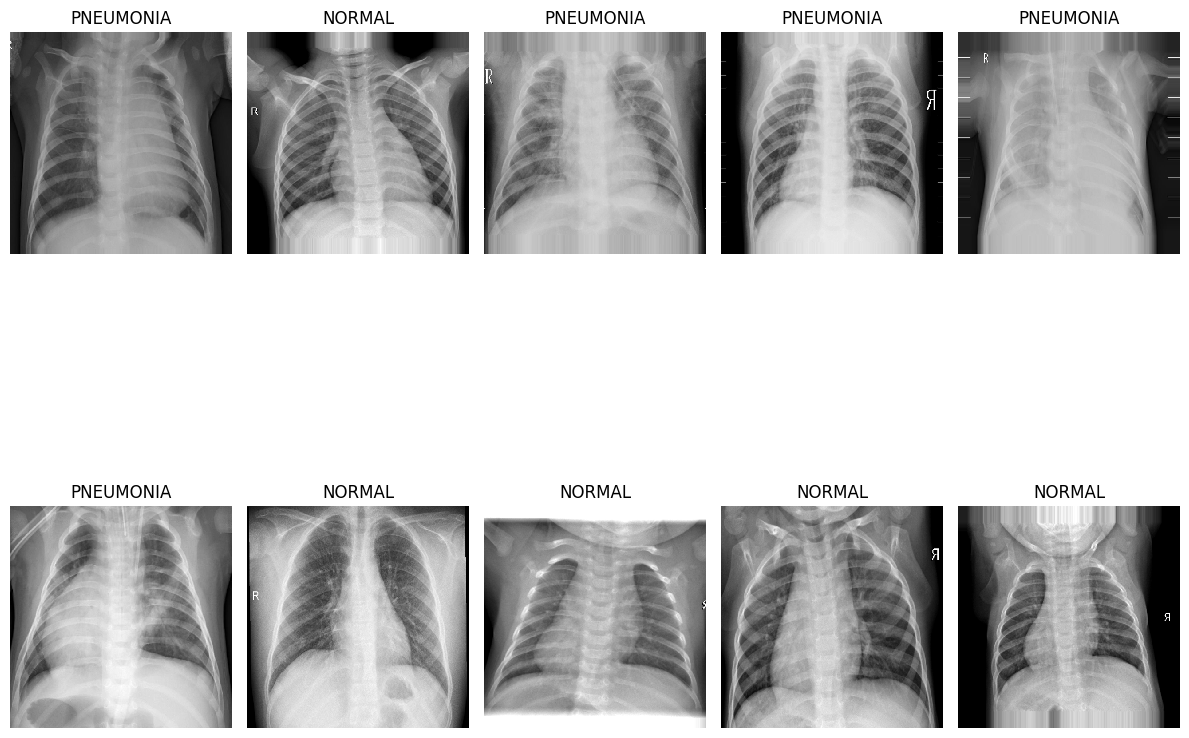

In [ ]:
# Train has the images, and the labels.
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
train.labels.shape

(5216,)

#### Creating the CNN architecture :

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 249, 249, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 60, 60, 32)       

In [ ]:
# Interpreting the parameters of my CNN :
''' Hyperparameters of Conv2D
Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(height,width,color channel)
    )
# Hyperparameters of MaxPooling2D
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )
    '''

' Hyperparameters of Conv2D\nConv2D(\n    filters,\n    kernel_size,\n    strides=(1, 1),\n    padding="valid",\n    activation=None,\n    input_shape=(height,width,color channel)\n    )\n# Hyperparameters of MaxPooling2D \nMaxPooling2D(\n    pool_size=(2, 2), strides=None, padding="valid"\n    )\n    '

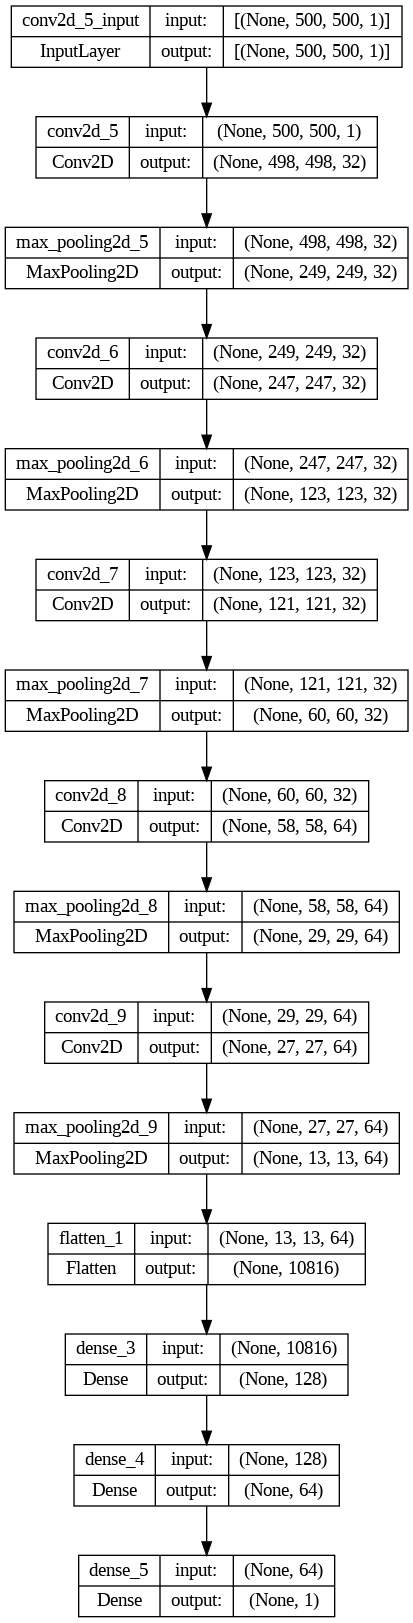

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

#### Using techniques to avoid overfitting :

In [ ]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]
#callbacks_list = [learning_rate_reduction]

In [ ]:
np.unique(train.classes, return_counts=True)

(array([0, 1], dtype=int32), array([1341, 3875]))

In [ ]:
train.labels.shape

(5216,)

#### Assigning Class Weights :

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Example class labels
class_labels = np.array([0, 1])

# Compute class weights using 'balanced' mode
weights = compute_class_weight('balanced', classes=np.unique(train.classes), y=train.labels)

# Create a dictionary mapping class labels to their corresponding weights
cw = dict(zip(class_labels, weights))

print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


#### Training my model :

In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
326/326 [==============================] - 140s 419ms/step - loss: 0.4035 - accuracy: 0.8000 - val_loss: 0.3767 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/25
326/326 [==============================] - 131s 402ms/step - loss: 0.2430 - accuracy: 0.9003 - val_loss: 0.4872 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/25
326/326 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9091
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 132s 404ms/step - loss: 0.2184 - accuracy: 0.9091 - val_loss: 0.9201 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/25
326/326 [==============================] - 132s 405ms/step - loss: 0.1691 - accuracy: 0.9304 - val_loss: 0.4621 - val_accuracy: 0.8125 - lr: 3.0000e-04


#### Evaluating my model :

<Axes: >

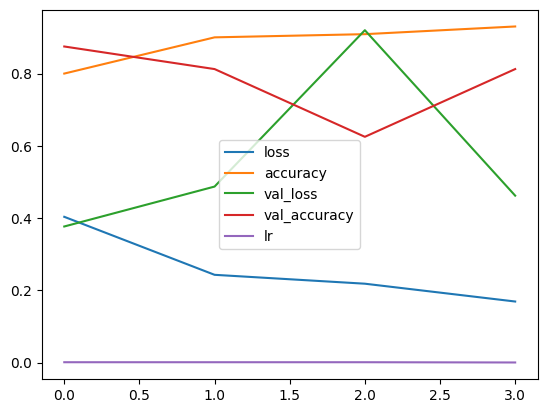

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 5s 118ms/step - loss: 0.2918 - accuracy: 0.8798
The testing accuracy is : 87.9807710647583 %


In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 4s 92ms/step


In [ ]:
preds

array([[0.23305354],
       [0.64759403],
       [0.4747057 ],
       [0.10234238],
       [0.13604124],
       [0.12885763],
       [0.21428934],
       [0.5913714 ],
       [0.35855618],
       [0.73170996],
       [0.1998947 ],
       [0.89484423],
       [0.26351592],
       [0.30671874],
       [0.23570418],
       [0.37220958],
       [0.9650263 ],
       [0.6866081 ],
       [0.17171626],
       [0.33571044],
       [0.49804047],
       [0.22312829],
       [0.19623272],
       [0.21280798],
       [0.26061806],
       [0.13652433],
       [0.52437747],
       [0.05487773],
       [0.5355323 ],
       [0.6574748 ],
       [0.5463683 ],
       [0.68635577],
       [0.37548357],
       [0.3762691 ],
       [0.48184204],
       [0.11029602],
       [0.00371616],
       [0.24438873],
       [0.05548657],
       [0.07966407],
       [0.15574132],
       [0.1227747 ],
       [0.12394252],
       [0.0257567 ],
       [0.10934116],
       [0.26166978],
       [0.49261656],
       [0.441

In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1
predictions

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

<Axes: >

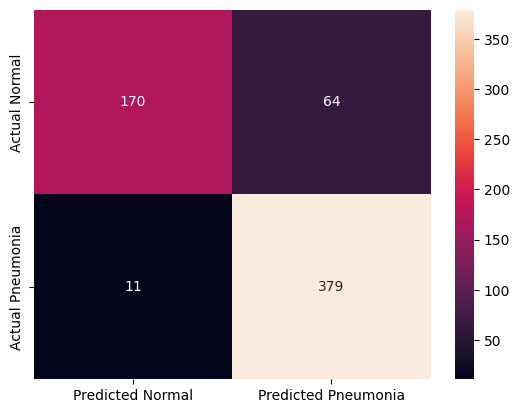

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.73      0.82       234
   PNEUMONIA       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.86       624
weighted avg       0.89      0.88      0.88       624



#### Visualising the predictions :

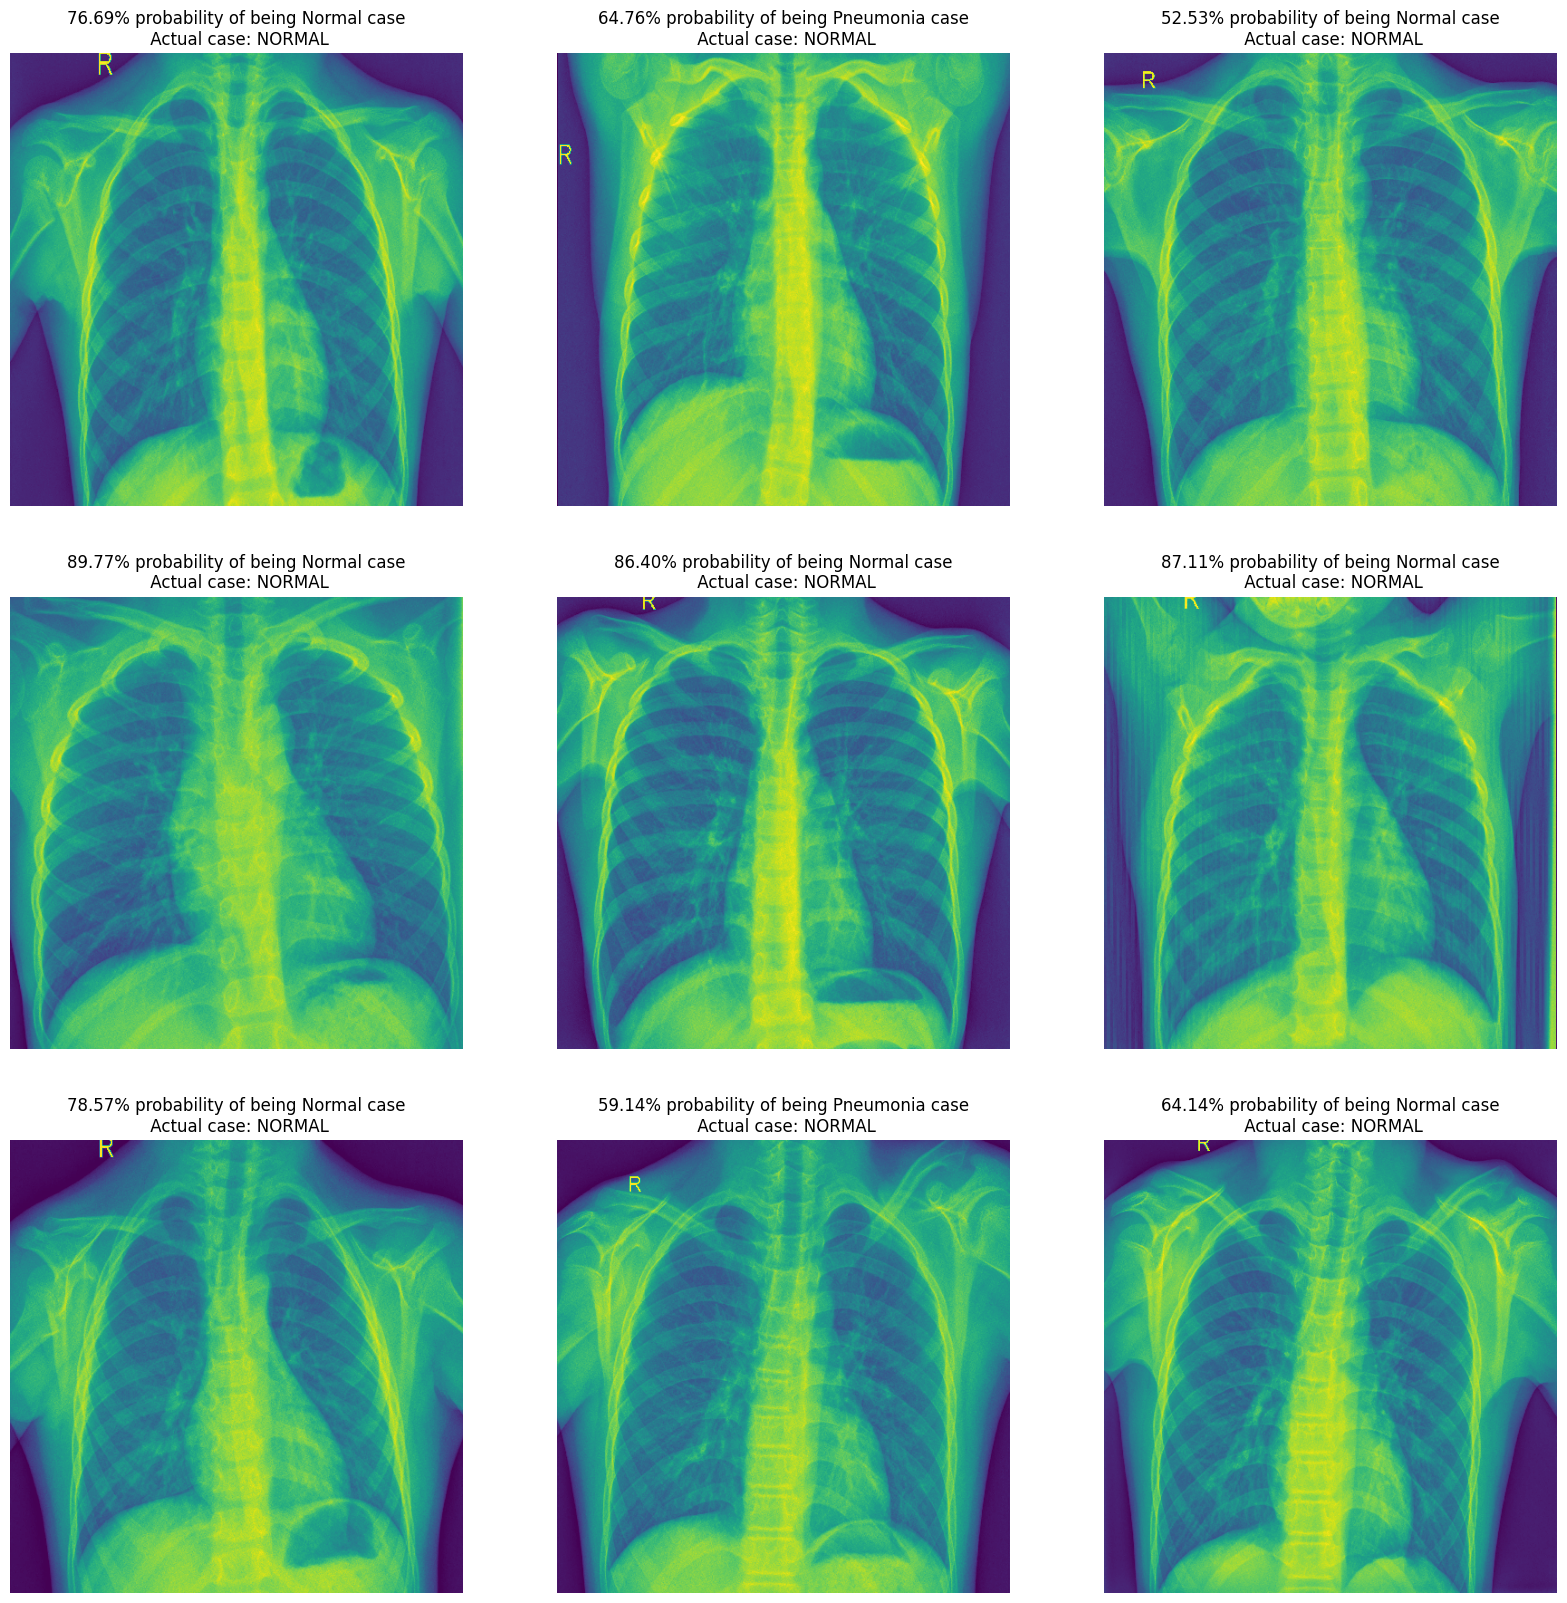

In [ ]:
# Assuming `test` is a data generator or iterator
test.reset()

# Collect all batches of data
num_batches = len(test)
x_batches = []
y_batches = []

for i in range(num_batches):
    batch_x, batch_y = test.next()
    x_batches.append(batch_x)
    y_batches.append(batch_y)

# Concatenate batches into numpy arrays
x = np.concatenate(x_batches)
y = np.concatenate(y_batches)

# Assuming `preds` is your predictions for `x`
# Example logic for plotting
dic = {0: 'NORMAL', 1: 'PNEUMONIA'}
plt.figure(figsize=(20, 20))

for i in range(min(len(x), 9)):
    plt.subplot(3, 3, i + 1)
    if preds[i, 0] >= 0.5:
        out = '{:.2%} probability of being Pneumonia case'.format(preds[i][0])
    else:
        out = '{:.2%} probability of being Normal case'.format(1 - preds[i][0])

    plt.title(out + "\n Actual case: " + dic.get(int(y[i])))
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')

plt.show()


#### Testing the new images :

In [ ]:
!gdown --id 12VuOVdm7qfLT4Y_lYsiaKihLEnCaLU_2 --output normal.png
!gdown --id 12V16VJkXG1bK1L6vfkQ7Zq378qcTt0Pg --output pneumonia.png

1/1 [==============================] - 0s 208ms/step


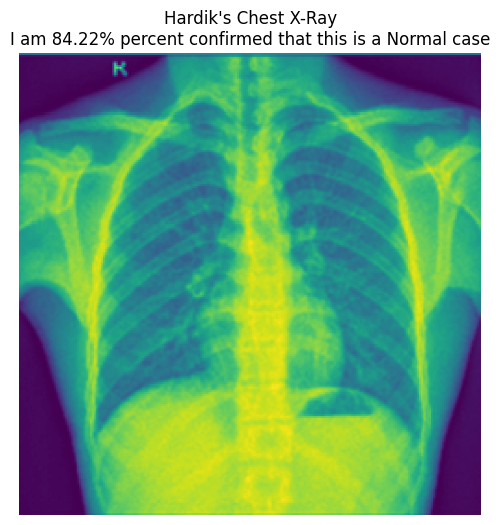

In [ ]:
# Testing with my own Chest X-Ray
hardik_path = '/content/normal.png'

from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))
plt.title("Hardik's Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

1/1 [==============================] - 0s 35ms/step


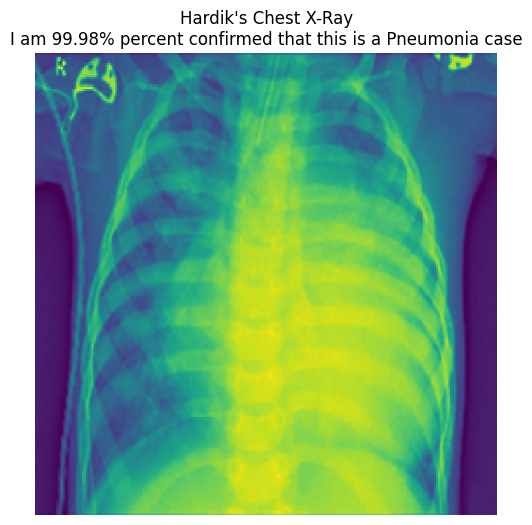

In [ ]:
# Testing with my own Chest X-Ray
hardik_path = '/content/pneumonia.png'

from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))
plt.title("Hardik's Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

In [ ]:
predictions

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],